In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from numpy.fft import rfft, irfft
import scipy.signal as sig
from glob import glob
twopi = 2*np.pi

from pycbc.filter import resample_to_delta_t, highpass, matched_filter, sigma, match, overlap
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.types import FrequencySeries
from pycbc import frame
from pycbc.psd import analytical

from tqdm import tqdm

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [2]:
tlen = 4
srate = 4096
f_low = 10.

psd = analytical.aLIGO140MpcT1800545(1+tlen*srate//2, delta_f=1/8, low_freq_cutoff=f_low)

kw = {'psd': psd, 'low_frequency_cutoff': f_low}

In [3]:
freqs = psd.sample_frequencies
def glitch(f0, gbw):
    tmp = np.exp(-0.5*gbw*(np.log(freqs) - np.log(f0))**2)
    return FrequencySeries(tmp, delta_f=psd.delta_f, dtype=np.complex128)

In [4]:
from numpy.random import default_rng
rng=default_rng(seed=28)

In [6]:
min_match = 0.98
place = []
bank = np.array([(15.,3.)])
tmplts = [glitch(*(bank[0]))]

In [34]:
for ii in tqdm(range(50000)):
    par_new = (rng.uniform(10.,600.), 2**rng.uniform(-2,3))
    g_new = glitch(*par_new)
    match1 = [overlap(g_new, gg, **kw) for gg in tmplts]
    if np.max(match1) < min_match:
        place.append(1)
        bank = np.concatenate((bank, [par_new]))
        tmplts.append(g_new)
    else:
        place.append(0)

100%|█████████████████████████████████████| 30000/30000 [05:52<00:00, 85.10it/s]


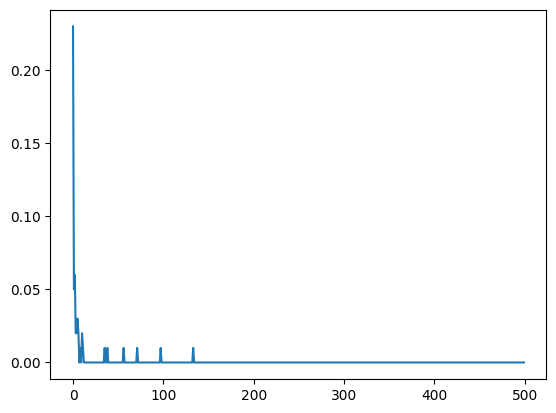

In [35]:
plt.plot([np.mean(place[ii:ii+100]) for ii in range(0,len(place),100)])

In [36]:
len(bank)

54

In [38]:
np.save('../data/TB_antiglitch_aLIGO140Mpc_98.npy', bank)

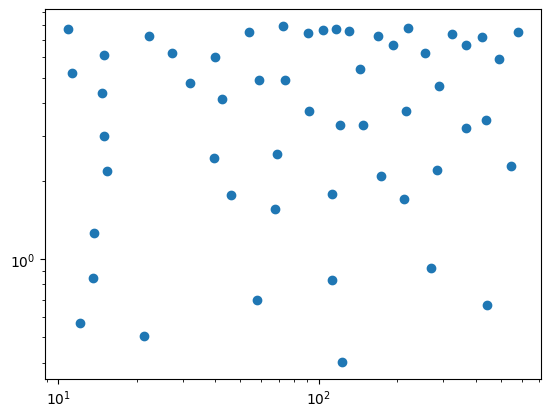

In [33]:
plt.scatter(bank[:,0], bank[:,1])
plt.xscale('log')
plt.yscale('log')

In [26]:
def qtile(f0, q):
    df = f0*np.sqrt(11.)/q
    tmp = np.where(np.abs(freqs-f0) < df, (1. - ((freqs-f0)/df)**2)**2, 0.)
    return FrequencySeries(tmp, delta_f=psd.delta_f, dtype=np.complex128)

In [27]:
f0grd, qgrd = np.meshgrid(np.arange(10,400, 5), np.logspace(np.log10(5.), np.log10(20), 11))

In [28]:
f0grd.shape

(11, 78)

In [29]:
g3 = glitch(75.407, 0.672)
matches = np.array([[overlap(qtile(f0grd[j,i], qgrd[j,i]), g3, **kw)
                        for i in range(78)] for j in range(11)])

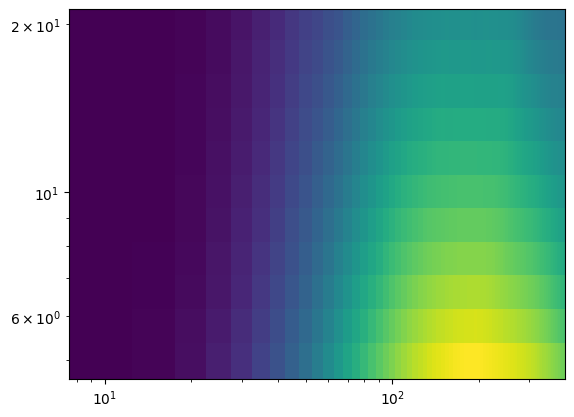

In [30]:
plt.pcolormesh(f0grd, qgrd, matches)
plt.xscale('log')
plt.yscale('log')

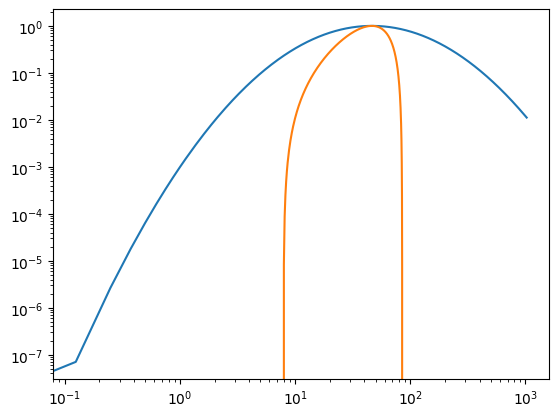

In [32]:
plt.loglog(freqs, glitch(46.5, 0.94))
plt.loglog(freqs, np.abs(qtile(46.5, 4)))